In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
input_directory ="C:/Users/daneb/Documents/GitHub/tdk/data"
noised_output = "noised_point_clouds"
colored_output = "colored_noise_point_clouds"

In [3]:
def create_noised_point_clouds(input_dir, output_dir_noised, output_dir_colored, num_points=30000, noise_std=0.01, noise_ratio=0.15):
   
    if not 0.0 <= noise_ratio <= 1.0:
        raise ValueError("noise_ratio must be between 0.0 and 1.0")
    
    noise_percentage = int(noise_std * 100)
    ratio_percentage = int(noise_ratio * 100)
    
    output_dir_noised = f"{output_dir_noised}_{noise_percentage}%noise_{ratio_percentage}%ratio_{num_points}pts"
    output_dir_colored = f"{output_dir_colored}_{noise_percentage}%noise_{ratio_percentage}%ratio_{num_points}pts"
    
    os.makedirs(output_dir_noised, exist_ok=True)
    os.makedirs(output_dir_colored, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.xyz'):
            filepath = os.path.join(input_dir, filename)
            points = np.loadtxt(filepath)

            if points.shape[1] > 3:
                points = points[:, :3]

            n_noise = int(num_points * noise_ratio)
            n_original = num_points - n_noise
            
            if len(points) > n_original:
                original_points = points[np.random.choice(len(points), n_original, replace=False)]
            else:
                pad_indices = np.random.choice(len(points), n_original - len(points), replace=True)
                original_points = np.vstack([points, points[pad_indices]])
            
            if n_noise > 0:
                noise_base_indices = np.random.choice(len(original_points), n_noise, replace=True)
                noise_points = original_points[noise_base_indices] + np.random.normal(0, noise_std, (n_noise, 3))
            else:
                noise_points = np.empty((0, 3))
            
            if n_noise > 0:
                combined_points = np.vstack([original_points, noise_points])
            else:
                combined_points = original_points
                
            labels = np.zeros(num_points, dtype=int)
            labels[n_original:] = 1  
            
            output_path = os.path.join(output_dir_noised, f"noised_{filename}")
            np.savetxt(output_path, combined_points, fmt='%.6f')
            
            label_path = os.path.join(output_dir_noised, f"labels_{filename.replace('.xyz', '.txt')}")
            np.savetxt(label_path, labels, fmt='%d')
            
            colored_points = np.zeros((num_points, 6))
            colored_points[:, :3] = combined_points
            colored_points[:n_original, 3:] = [0, 0, 0]  
            colored_points[n_original:, 3:] = [1, 0, 0]  
            
            colored_path = os.path.join(output_dir_colored, f"colored_{filename}")
            np.savetxt(colored_path, colored_points, fmt='%.6f')

    print(f"Created datasets in {output_dir_noised}")
    print(f"Noise ratio: {noise_ratio:.1%} ({n_noise}/{num_points} points)")

In [4]:
create_noised_point_clouds(input_directory, noised_output, colored_output,30000,0.01)

Created datasets in noised_point_clouds_1%noise_15%ratio_30000pts
Noise ratio: 15.0% (4500/30000 points)


In [8]:
def visualize_noise_model(model_name, 
                        base_colored_dir="colored_noise_point_clouds",
                        noise_std=0.01,
                        noise_ratio=0.15,
                        num_points=30000):
    
    
    noise_percentage = int(noise_std * 100)
    ratio_percentage = int(noise_ratio * 100)
    colored_dir = f"{base_colored_dir}_{noise_percentage}%noise_{ratio_percentage}%ratio_{num_points}pts"
    colored_file = f"{colored_dir}/colored_{model_name}.xyz"
    
    colored_data = np.loadtxt(colored_file)
    
    n_noise = int(num_points * noise_ratio)
    n_original = num_points - n_noise
    
    original_points = colored_data[:n_original, :3]
    noised_points = colored_data[n_original:, :3]
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    if len(noised_points) > 0:
        ax.scatter(noised_points[:, 0], noised_points[:, 1], noised_points[:, 2], 
                   c='#ff4444', s=2, alpha=0.8, label=f'Noised ({len(noised_points)})', 
                   edgecolors='none')
    
    ax.scatter(original_points[:, 0], original_points[:, 1], original_points[:, 2], 
               c='#2E86AB', s=1.5, alpha=0.9, label=f'Original ({len(original_points)})',
               edgecolors='none')
    
    ax.set_xlabel('X', fontsize=11)
    ax.set_ylabel('Y', fontsize=11)
    ax.set_zlabel('Z', fontsize=11)
    ax.set_title(f"Point Cloud: '{model_name}'\nNoise: {noise_percentage}% std, {ratio_percentage}% ratio", 
                 fontsize=13, pad=20)
    
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.set_facecolor('white')
    ax.grid(True, alpha=0.3)
    
    ax.view_init(elev=15, azim=45)
    
    ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    plt.show()


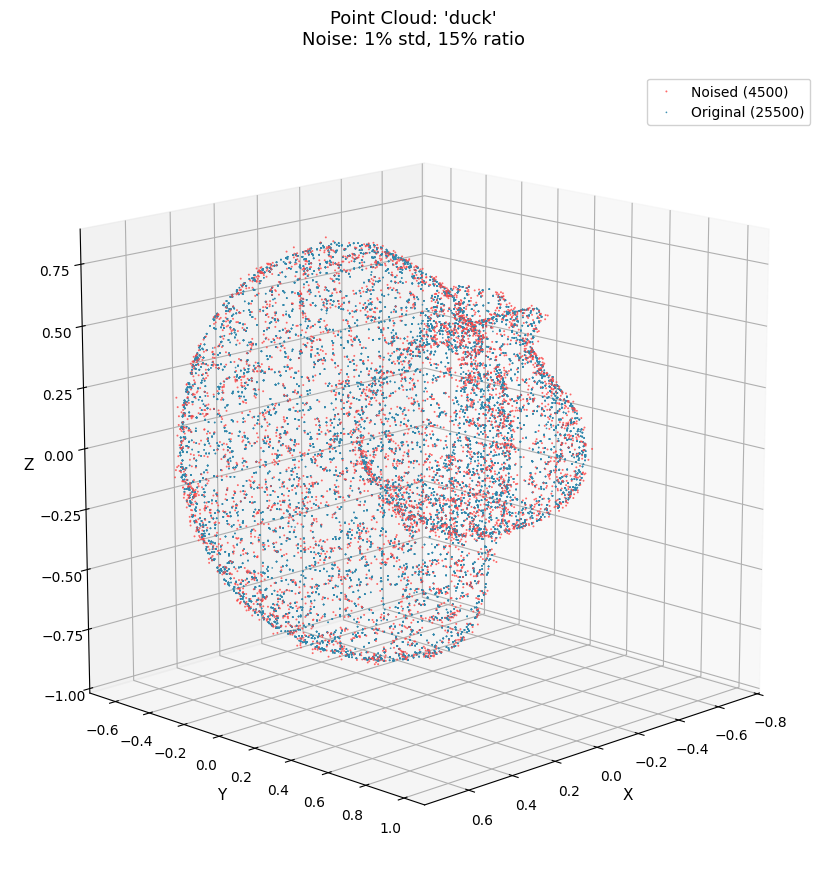

In [10]:
visualize_noise_model("duck", noise_std=0.01, noise_ratio=0.15, num_points=30000)